# Presentación

#### Algunos imports necesarios

In [1]:
import $ivy.`org.apache.spark::spark-sql:2.4.3`


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window



//Reducir numero logs
import org.apache.log4j.{Level, Logger}
Logger.getLogger("org").setLevel(Level.OFF)


//Sttp para realizar request
import $ivy.`com.softwaremill.sttp.client::async-http-client-backend-monix:2.0.0-RC2`
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest


//For adding extra dependenies
import $ivy.`org.typelevel::cats-core:1.6.0`

//Plotly
import $ivy.`org.plotly-scala::plotly-almond:0.8.3`
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark
val spark = {
  NotebookSparkSession.builder()
     .master("local[*]")
    //.config("spark.executor.instances", "4") // Número de ejecutores
    //.config("spark.executor.memory", "4g") // Memoria por ejecutor
    //.config("spark.executor.cores", "2") // Núcleos por ejecutor
    //.config("spark.driver.memory", "4g") // Memoria del driver
    //.config("spark.sql.shuffle.partitions", "8") // Número de particiones para operaciones de shuffle
    .getOrCreate()
}
import spark.implicits._

Loading spark-stubs

Creating SparkSession

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties


Spark UI

import $ivy.$
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.expressions.Window
import org.apache.log4j.{Level, Logger}
import $ivy.$
import sttp.client.quick.{quickRequest, UriContext, backend}
import sttp.client.asynchttpclient.monix._
import sttp.client.basicRequest
import $ivy.$
import $ivy.$
import plotly._, plotly.element._, plotly.layout._, plotly.Almond._


//Iniciamos session de Spark

spark: SparkSession = org.apache.spark.sql.SparkSession@498b63e0
import spark.implicits._

## Proceso ETL: Extracción, Transformación y Carga de los datos.

Proceso aplicado a los datos obtenidos desde la API, preparandolos para su posterior analisis y visualización.

### Extracción

##### Creación URI
El codigo que vemos en la siguiente celda construye una URL para hacer la llamada a la API de REE. La función tiene varios parámetros, algunos obligatorios y otros opcionales.

In [2]:
def createUri(category: String, widget: String, start_date: String, end_date: String, time_trunc: String, lang: String, 
              geo_trunc: String = "", geo_limit: String = "", geo_ids: String = ""): String = {
  val baseUrl = s"https://apidatos.ree.es/$lang/datos/$category/$widget"
  
// Crear un mapa con los parámetros obligatorios y opcionales
  val params = Map(
    "start_date" -> start_date,
    "end_date" -> end_date,
    "time_trunc" -> time_trunc,
    "geo_trunc" -> geo_trunc,
    "geo_limit" -> geo_limit,
    "geo_ids" -> geo_ids
  ).filter { case (_, v) => v.nonEmpty } // Filtrar los parámetros que no están vacíos

//Especifico el orden concreto de los paramtros ya que, Scala map no te garantiza el orden
  val orderedKeys = Seq("start_date", "end_date", "time_trunc", "geo_trunc", "geo_limit", "geo_ids")

// Unir los parámetros en una cadena
  val queryString = orderedKeys.flatMap(key => params.get(key).map(value => s"$key=$value")).mkString("&")
  
  s"$baseUrl?$queryString"
}

defined function createUri

In [3]:
// Doy valor a los parámetros para llamar a la API

val category = "balance"
val widget = "balance-electrico"
val time_trunc = "day"
val lang = "es"

val start = "2024-01-01T00:00"
val end = "2024-12-31T00:00"

val uri = createUri(category, widget, start, end, time_trunc, lang) //Solo le paso los valores obligatorios

category: String = "balance"
widget: String = "balance-electrico"
time_trunc: String = "day"
lang: String = "es"
start: String = "2024-01-01T00:00"
end: String = "2024-12-31T00:00"
uri: String = "https://apidatos.ree.es/es/datos/balance/balance-electrico?start_date=2024-01-01T00:00&end_date=2024-12-31T00:00&time_trunc=day"

##### Hacer llamada y guardar datos
Con la función getDataApi realizamos la solicitud GET a la API utilizando la URL que ya hemos creado. Usa basicRequest.get y devuelve un Either para detectar posibles errores.

In [4]:
def getDataApi(apiUrl: String): Either[String, String] = {
 
    val newRequest = basicRequest.get(uri"$apiUrl")
    val response = newRequest.send()
  
  response.body match {
    case Right(body) => 
      Right(body)
      
    case Left(error) => 
      Left(s"Error fetching data: $error")
  }
}

defined function getDataApi

In [5]:
val response = getDataApi(uri)

response: Either[String, String] = Right(
  "{\"data\":{\"type\":\"Balance de energ\\u00eda el\\u00e9ctrica\",\"id\":\"bal1\",\"attributes\":{\"title\":\"Balance de energ\\u00eda el\\u00e9ctrica\",\"last-update\":\"2025-01-28T16:56:22.000+01:00\",\"description\":\"Balance el\\u00e9ctrico: asignaci\\u00f3n de unidades de producci\\u00f3n seg\\u00fan combustible principal.\"},\"meta\":{\"cache-control\":{\"cache\":\"HIT\",\"expireAt\":\"2025-03-14T12:31:44\"}}},\"included\":[{\"type\":\"Renovable\",\"id\":\"Renovable\",\"attributes\":{\"title\":\"Renovable\",\"last-update\":\"2025-01-28T16:56:17.000+01:00\",\"description\":null,\"magnitude\":null,\"content\":[{\"type\":\"Hidr\\u00e1ulica\",\"id\":\"10288\",\"groupId\":\"Renovable\",\"attributes\":{\"title\":\"Hidr\\u00e1ulica\",\"description\":\"10288\",\"color\":\"#0090d1\",\"type\":\"distinct\",\"magnitude\":null,\"composite\":false,\"last-update\":\"2025-01-28T16:56:17.000+01:00\",\"values\":[{\"value\":58381.148,\"percentage\":0.1971

##### Guardamos el texto plano en un dataframe
Con esta función transformamos la respuesta en texto plano que nos da la API en un DataFrame de Spark. 

In [9]:
// Transformar response a DataFrame
def responseToDF(response: Either[String, String]): DataFrame = {
    response match {
    case Right(body) => 
        val dataset: Dataset[String] = Seq(body).toDS() // Convertir a Dataset[String]
        spark.read.json(dataset) // Leer JSON desde Dataset
    case Left(error) => 
        println(error)
        spark.emptyDataFrame
    }
}

defined function responseToDF

In [10]:
val datosSinLimpiar = responseToDF(response)

datosSinLimpiar: DataFrame = [data: struct<attributes: struct<description: string, last-update: string ... 1 more field>, id: string ... 2 more fields>, included: array<struct<attributes:struct<content:array<struct<attributes:struct<color:string,composite:boolean,description:string,last-update:string,magnitude:string,title:string,total:double,type:string,values:array<struct<datetime:string,percentage:double,value:double>>>,groupId:string,id:string,type:string>>,description:string,last-update:string,magnitude:string,title:string>,id:string,type:string>>]

In [11]:
datosSinLimpiar.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- attributes: struct (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- last-update: string (nullable = true)
 |    |    |-- title: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- meta: struct (nullable = true)
 |    |    |-- cache-control: struct (nullable = true)
 |    |    |    |-- cache: string (nullable = true)
 |    |    |    |-- expireAt: string (nullable = true)
 |    |-- type: string (nullable = true)
 |-- included: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attributes: struct (nullable = true)
 |    |    |    |-- content: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- attributes: struct (nullable = true)
 |    |    |    |    |    |    |-- color: string (nullable = true)
 |    |    |    |    |    |    |-- composite: boolean (nullable = true)
 |    |    |   

### Transformación

In [12]:
// Importar implicits para poder usar $"columnName"
import spark.implicits._

def transformToBalanceModel(df: DataFrame): DataFrame = {


    // Definir los tipos de energía de bajas emisiones
    val bajasEmisiones = Seq(
        "Solar fotovoltaica", 
        "Solar térmica", 
        "Nuclear", 
        "Hidroeólica", 
        "Eólica", 
        "Generación renovable", 
        "Otras renovables",
        "Hidráulica", 
        "Residuos renovables"

    )

    //Crear modelo desanidado
    df.withColumn("FamilyGroup", explode($"included"))
        .withColumn("TypeGroup", explode($"FamilyGroup.attributes.content"))
        .withColumn("Values", explode($"TypeGroup.attributes.values"))
        .select(
            $"FamilyGroup.type".as("Familia"),
            $"TypeGroup.type".as("Tipo"),
            $"TypeGroup.attributes.composite".as("Compuesto"),
            $"Values.datetime".cast("timestamp").as("FechaAux"), 
            $"Values.percentage".as("Porcentaje"),
            $"Values.value".as("Valor")
        )
        .withColumn("Fecha", expr("FechaAux + INTERVAL 1 HOUR"))
        .withColumn("BajasEmisiones", $"Tipo".isin(bajasEmisiones: _*))
        .withColumn("Año", year($"Fecha"))
        .withColumn("Mes", month($"Fecha"))
        .drop($"FechaAux")
}

import spark.implicits._
defined function transformToBalanceModel

In [13]:
val modelBalance = transformToBalanceModel(datosSinLimpiar)

modelBalance: DataFrame = [Familia: string, Tipo: string ... 7 more fields]

In [14]:
modelBalance.show()

+---------+----------+---------+-------------------+----------+-------------------+--------------+----+---+
|  Familia|      Tipo|Compuesto|         Porcentaje|     Valor|              Fecha|BajasEmisiones| Año|Mes|
+---------+----------+---------+-------------------+----------+-------------------+--------------+----+---+
|Renovable|Hidráulica|    false|0.19718853720380722| 58381.148|2024-01-01 01:00:00|          true|2024|  1|
|Renovable|Hidráulica|    false|0.15570440748011716| 68004.167|2024-01-02 01:00:00|          true|2024|  1|
|Renovable|Hidráulica|    false|0.22015731350369466|  93862.43|2024-01-03 01:00:00|          true|2024|  1|
|Renovable|Hidráulica|    false|0.44288074417231343|139605.013|2024-01-04 01:00:00|          true|2024|  1|
|Renovable|Hidráulica|    false|0.17956310101675974| 83467.494|2024-01-05 01:00:00|          true|2024|  1|
|Renovable|Hidráulica|    false|0.16387300585655923| 77899.805|2024-01-06 01:00:00|          true|2024|  1|
|Renovable|Hidráulica|    fa

### Carga (Almacenamiento de datos)

La ultima parte de esta ETL. Guardamos el modelo que hemos creado en un formato de almacenamiento optipo para el procesamiento de datos. El fichero Parquet aprovecha optimizaciones de Spark, por un lado tiene un formato columnar y por otro permite el particionamiento. Spark aprovecha todas estas optimizaciones en la posterior lectura.

In [16]:
modelBalance.write
            .mode("overwrite")
            .partitionBy("Año", "Mes") 
            .parquet("data/parquet/dsBalance2024.parquet")

##### Copmparación Parquet y CSV
En esta sección, analizamos el impacto del formato de almacenamiento en el rendimiento de las consultas en **Apache Spark**.

In [17]:
val pathCsv = "../data/csv/dsBalanceNacionalAnalisis.csv"      
val pathParquet = "../data/parquet/dsBalanceNacionalParticionado.parquet"

// Medir tiempo de lectura CSV
val startCsv = System.nanoTime()
val dfFromCsv: DataFrame = spark.read
    .option("header", "true") // Para que Spark lea la primera linea como encabezado
    .option("inferSchema", "true") // Para inferir automáticamente el esquema
    .csv(pathCsv)
val endCsv = System.nanoTime()
println(s"Tiempo de lectura CSV: ${(endCsv - startCsv) / 1e9} segundos")


// Medir tiempo de lectura Parquet
val startParquet = System.nanoTime()
val dfFromParquet: DataFrame = spark.read.parquet(pathParquet)
val endParquet = System.nanoTime()
println(s"Tiempo de lectura Parquet: ${(endParquet - startParquet) / 1e9} segundos")

// Ver esquema
dfFromCsv.explain()
dfFromParquet.explain()

Tiempo de lectura CSV: 1.5124937 segundos


Tiempo de lectura Parquet: 0.4915436 segundos
== Physical Plan ==
*(1) FileScan csv [Familia#158,Tipo#159,Compuesto#160,Porcentaje#161,Valor#162,Fecha#163,BajasEmisiones#164,Año#165,Mes#166] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/C:/Proyectos/spark-datos-energia/data/csv/dsBalanceNacionalAnalisis.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Familia:string,Tipo:string,Compuesto:boolean,Porcentaje:double,Valor:double,Fecha:timestam...
== Physical Plan ==
*(1) FileScan parquet [Familia#176,Tipo#177,Compuesto#178,Porcentaje#179,Valor#180,Fecha#181,BajasEmisiones#182,Año#183,Mes#184] Batched: true, Format: Parquet, Location: InMemoryFileIndex[file:/C:/Proyectos/spark-datos-energia/data/parquet/dsBalanceNacionalParticiona..., PartitionCount: 169, PartitionFilters: [], PushedFilters: [], ReadSchema: struct<Familia:string,Tipo:string,Compuesto:boolean,Porcentaje:double,Valor:double,Fecha:timestam...


pathCsv: String = "../data/csv/dsBalanceNacionalAnalisis.csv"
pathParquet: String = "../data/parquet/dsBalanceNacionalParticionado.parquet"
startCsv: Long = 1384894246005100L
dfFromCsv: DataFrame = [Familia: string, Tipo: string ... 7 more fields]
endCsv: Long = 1384895758498800L
startParquet: Long = 1384895758937800L
dfFromParquet: DataFrame = [Familia: string, Tipo: string ... 7 more fields]
endParquet: Long = 1384896250481400L

## Visualización

Esta función compara la evolución de la energía renovable y no renovable mes a mes en un gráfico de líneas.

Agrupa y suma la producción de cada tipo de energía (Renovable y No-Renovable) por Año y Mes.
Convierte los resultados en secuencias (Seq) para pasarlas a Plotly.
Grafica ambas series en un gráfico de líneas, permitiendo visualizar tendencias y comparaciones a lo largo del año.

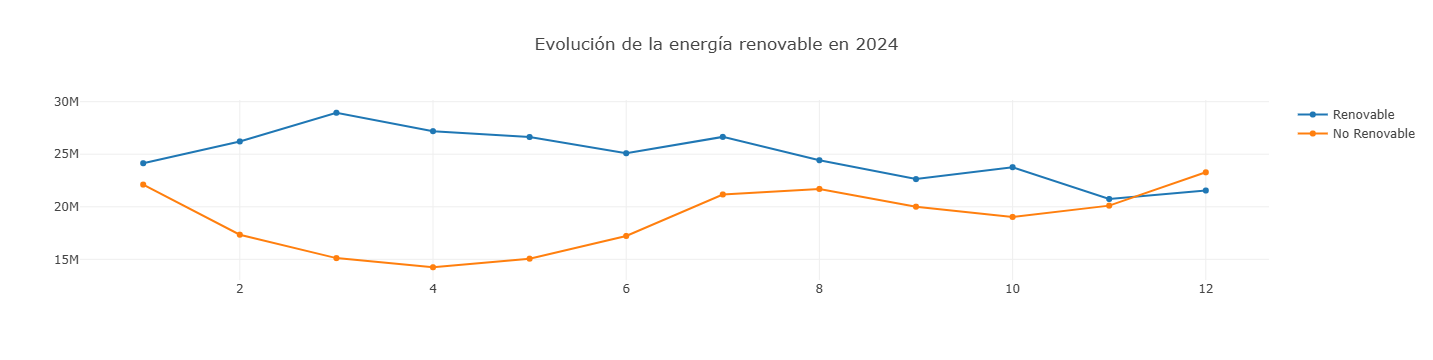

defined function renovableVSnoRenovable

In [18]:
def renovableVSnoRenovable(df: DataFrame): Unit = {
    
  val renovable = df
      .filter($"Familia" === "Renovable")
      .groupBy("Año", "Mes")
      .agg(sum("Valor").as("Valor"))
      .orderBy("Año", "Mes")
    
  val noRenovable = df
      .filter($"Familia" === "No-Renovable")
      .groupBy("Año", "Mes")
      .agg(sum("Valor").as("Valor"))
      .orderBy("Año", "Mes") 


  val meses = renovable.select($"Mes").as[Int].collect.toSeq    
  val seqRenovable = renovable.select($"Valor").as[Double].collect.toSeq
  val seqNoRenovable = noRenovable.select($"Valor").as[Double].collect.toSeq
  
    val traces = Seq(
        Scatter(meses, seqRenovable).withName("Renovable"),
        Scatter(meses, seqNoRenovable).withName("No Renovable")
    )

  val layout = Layout().withTitle("Evolución de la energía renovable en 2024")
  val data = traces
    
  plot(data, layout)
    
}

renovableVSnoRenovable(modelBalance)